# Goals and project scope

The project was aimed at predicting delivery time for a food delivery service. The scope of the project encompassed exploring data to understand trends and relationships, such as peak demand times and differences in delivery times across various markets. This provided valuable insights into the factors influencing delivery times. Subsequently, the project involved the application of machine learning algorithms, including Linear Regression and Random Forest, to construct a predictive model. An integral part of the project was the application of statistical methods like best subset selection and p-value calculations. This allowed for the identification of the most relevant predictors, ultimately contributing to improved accuracy and interpretability of the model. The overall objective was not only to accurately predict delivery times but also to understand the variables contributing most significantly to these predictions, thereby enabling strategic decision-making for the business.

In [ ]:
import copy
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm



np.random.seed(0)

gray_color = "#CCCCCC" # Grey for regular txs
red_color = "#F0544F" # Red for fraudulent txs
blue_color = "#8CA6F2" # Blue for heatmap
gold_color = '#F2D98C' # Gold for heatmap
green_color = '#A4F28C'# Green for confusion matrix
white_color = '#FFFFFF' # White for confusion matrix

In [2]:
df = pd.read_csv('historical_data.csv')

# EDA & Feature Engineering

In [3]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [5]:
print('From:', min(df['created_at']), 'To:' , max(df['created_at']))

From: 2014-10-19 05:24:15 To: 2015-02-18 06:00:44


In [6]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

In [7]:
df['total_delivery_time'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()

In [8]:
df['day_of_week'] = df['created_at'].dt.dayofweek
df['hour_of_day'] = df['created_at'].dt.hour
df['month'] = df['created_at'].dt.month

In [9]:
df

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,day_of_week,hour_of_day,month
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0,3779.0,4,22,2
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0,4024.0,1,21,2
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0,1781.0,3,20,1
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0,3075.0,1,21,2
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0,2390.0,6,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197423,1.0,2015-02-17 00:19:41,2015-02-17 01:24:48,2956,fast,4.0,3,1389,3,345,649,17.0,17.0,23.0,251,331.0,3907.0,1,0,2
197424,1.0,2015-02-13 00:01:59,2015-02-13 00:58:22,2956,fast,4.0,6,3010,4,405,825,12.0,11.0,14.0,251,915.0,3383.0,4,0,2
197425,1.0,2015-01-24 04:46:08,2015-01-24 05:36:16,2956,fast,4.0,5,1836,3,300,399,39.0,41.0,40.0,251,795.0,3008.0,5,4,1
197426,1.0,2015-02-01 18:18:15,2015-02-01 19:23:22,3630,sandwich,1.0,1,1175,1,535,535,7.0,7.0,12.0,446,384.0,3907.0,6,18,2


In [10]:
df.isna().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
total_delivery_time                                 7
day_of_week                                         0
hour_of_day                 

### Findings

- total_onshift_dashers, total_busy_dashers, and total_outstanding_orders have the same number of missing values.
    - We can fill them with the avg total_onshift_dashers at the same market id and created hour
- market_id:
    - We can drop them (0.5% of the data)
- actual_delivery_time & total_delivery_time:
    - drop them

In [11]:
df = df.dropna(subset=['market_id', 'actual_delivery_time'])


In [12]:
# Define a function to replace NaN values with the mean (or other metrics) of a specific group
def replace_nan_with_mean(df, columns, groupby, metric):
    # Iterate over each column specified in the 'columns' argument
    for col in columns:
        # For each column, calculate the metric (e.g. mean, median) 
        # for the specified group ('groupby' argument)
        mean_values = df.groupby(groupby)[col].transform(metric)
        
        # Replace the NaN values in the original column with the calculated metric values
        # The 'inplace=True' argument means that the original DataFrame 'df' is modified directly
        df.loc[df[col].isna(), col] = mean_values
    
    return df

In [13]:
df = replace_nan_with_mean(
    df, 
    ['total_onshift_dashers',
     'total_busy_dashers',
     'total_outstanding_orders'],
    ['market_id', 'hour_of_day'],
    'mean'
)


In [14]:
df[df['total_outstanding_orders'].isna()]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,day_of_week,hour_of_day,month
176119,6.0,2015-02-08 07:00:22,2015-02-08 07:51:00,5285,american,4.0,2,800,2,300,500,NaN,NaN,NaN,446,888.0,3038.0,6,7,2
183750,6.0,2015-02-14 07:00:55,2015-02-14 08:05:11,2215,japanese,1.0,5,2885,4,300,1095,NaN,NaN,NaN,446,949.0,3856.0,5,7,2



- We still have some records with Nan. The reason for that, for market_id 6.0 and hour_of_day 7, we have only two records with 'total_outstanding_orders' Nan which results in a Nan mean also.

- We can estimate these two records using the whole dataset mean.

In [15]:
df[(df['market_id'] == 6.0) & (df['hour_of_day'] == 7)]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,day_of_week,hour_of_day,month
176119,6.0,2015-02-08 07:00:22,2015-02-08 07:51:00,5285,american,4.0,2,800,2,300,500,NaN,NaN,NaN,446,888.0,3038.0,6,7,2
183750,6.0,2015-02-14 07:00:55,2015-02-14 08:05:11,2215,japanese,1.0,5,2885,4,300,1095,NaN,NaN,NaN,446,949.0,3856.0,5,7,2


In [16]:
# Fill remaining NaN values with the overall mean of 'total_onshift_dashers'
df = df.copy()

df.loc[:, 'total_onshift_dashers'] = df['total_onshift_dashers'].fillna(df['total_onshift_dashers'].mean())
df.loc[:, 'total_busy_dashers'] = df['total_busy_dashers'].fillna(df['total_busy_dashers'].mean())
df.loc[:, 'total_outstanding_orders'] = df['total_outstanding_orders'].fillna(df['total_outstanding_orders'].mean())

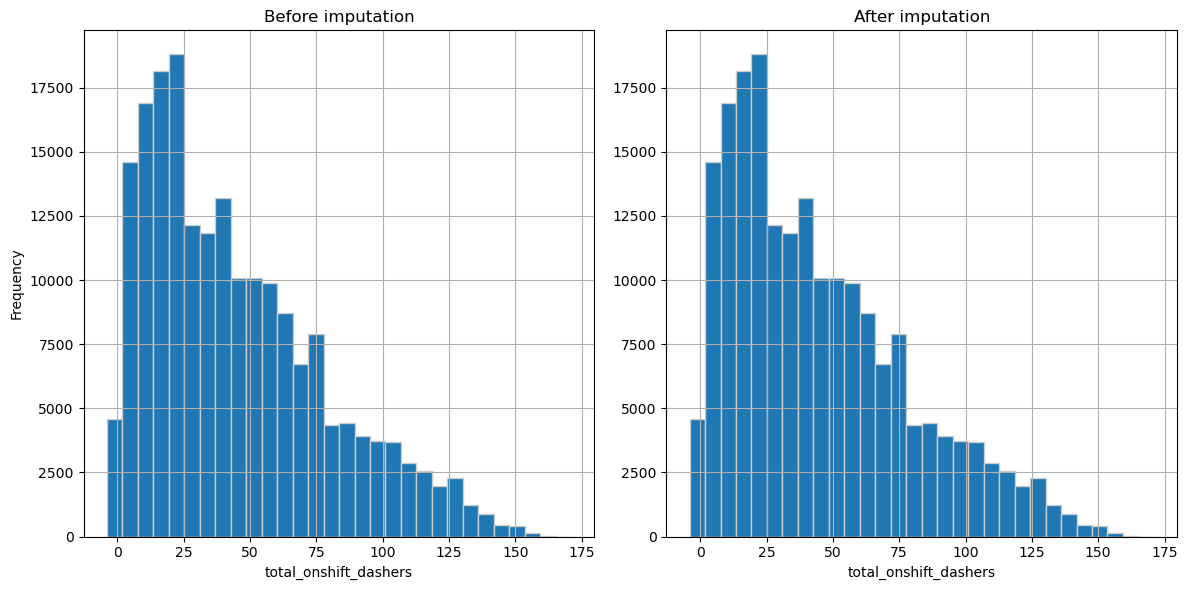

In [18]:
# Make sure distributions are the same before and after estimating 'total_onshift_dashers'
df_copy = copy.deepcopy(df)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
df_copy['total_onshift_dashers'].dropna().hist(bins=30, edgecolor=gray_color)
plt.title('Before imputation')
plt.xlabel('total_onshift_dashers')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df['total_onshift_dashers'].hist(bins=30, edgecolor=gray_color)
plt.title('After imputation')
plt.xlabel('total_onshift_dashers')

plt.tight_layout()
plt.show()

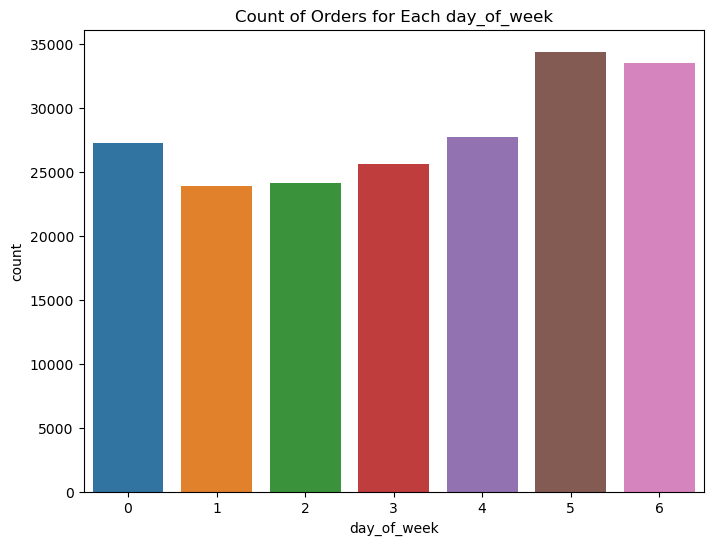

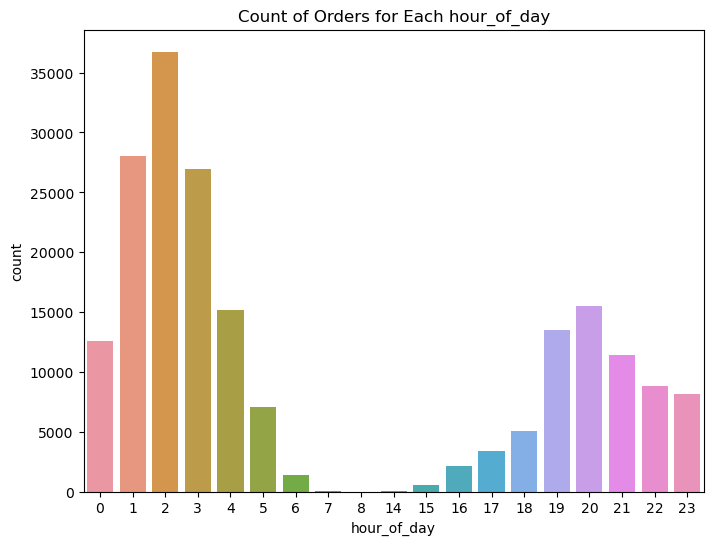

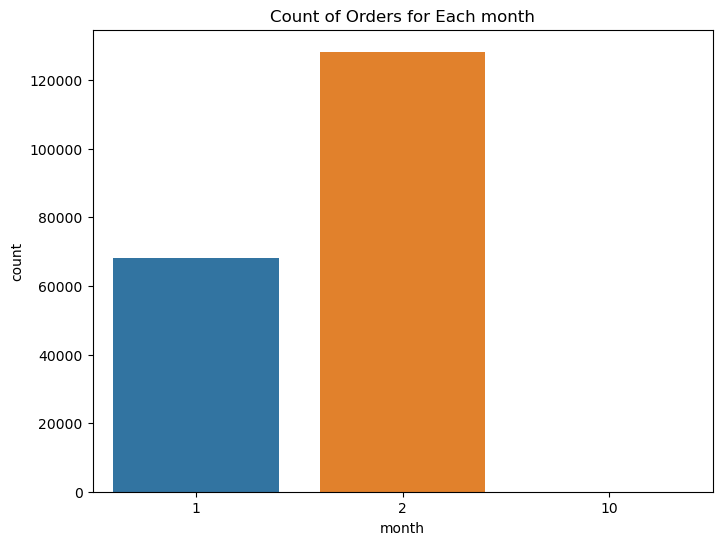

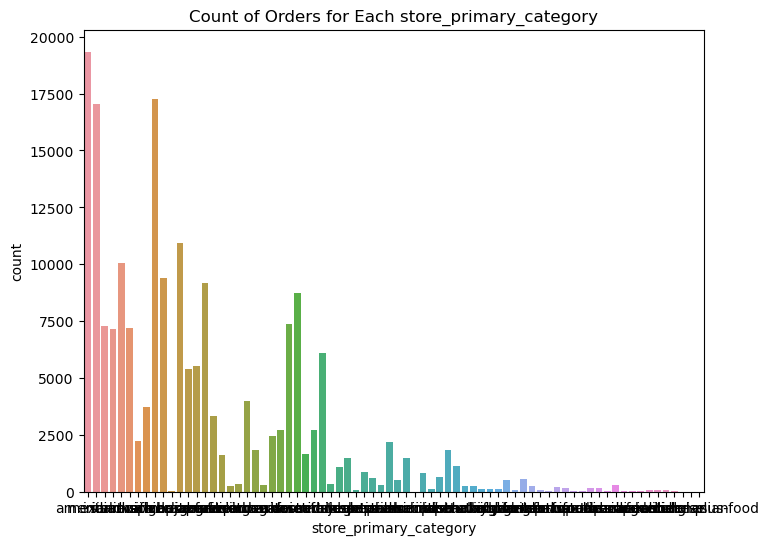

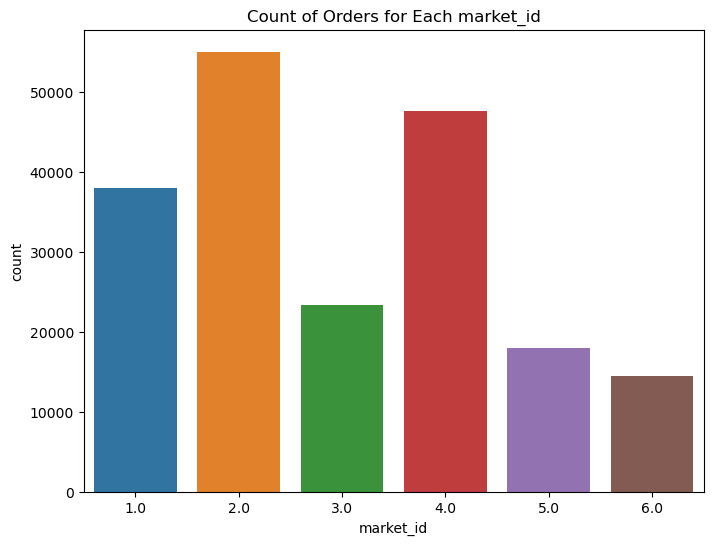

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_count(df, column_name):
    plt.figure(figsize=(8, 6))
    sns.countplot(x=column_name, data=df)
    plt.title(f'Count of Orders for Each {column_name}')
    plt.show()

# Now you can use this function to plot for each column
plot_count(df, 'day_of_week')
plot_count(df, 'hour_of_day')
plot_count(df, 'month')
plot_count(df, 'store_primary_category')
plot_count(df, 'market_id')

### Findings:

- Day 5 and 6 also have the highest orders (Weekend)
- We can detect three patterns out of the orders accross each day:
    - 12am -> 5am 
    - 6am  -> 3pm
    - 4pm  -> 11pm
- Market 2.0 and 4.0 have the highest demand
- Feburary has more orders than January (Roughly double)
 

In [28]:
df.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,day_of_week,hour_of_day,month
count,196434.000000,196434.000000,195926.000000,196434.000000,196434.000000,196434.000000,196434.000000,196434.000000,196434.000000,196434.000000,196434.000000,196434.000000,195909.000000,1.964340e+05,196434.000000,196434.000000,196434.000000
mean,2.978700,3530.472087,2.882185,3.196249,2682.366729,2.670790,686.315429,1159.704705,44.699045,41.654869,57.978908,308.575761,545.299705,2.908409e+03,3.219682,8.468875,1.653095
std,1.524879,2053.184065,1.503725,2.667770,1823.156066,1.630409,522.345360,558.604932,33.638770,31.289877,51.371745,90.149404,219.345707,1.927769e+04,2.045671,8.659225,0.476371
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,1.010000e+02,0.000000,0.000000,1.000000
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,800.000000,18.000000,16.000000,18.000000,251.000000,382.000000,2.104000e+03,1.000000,2.000000,1.000000
50%,3.000000,3591.500000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,35.000000,42.000000,251.000000,544.000000,2.660000e+03,3.000000,3.000000,2.000000
75%,4.000000,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.362832,61.000000,86.000000,446.000000,702.000000,3.381000e+03,5.000000,19.000000,2.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,8.516859e+06,6.000000,23.000000,10.000000


- For min_item_price, total_onshift_dashers, total_busy_dashers, and total_outstanding_orders we have negative values (Which does not make sense)
- It might be a system error so I will replace them with zero

In [31]:
df.loc[df.total_onshift_dashers < 0, 'total_onshift_dashers'] = 0
df.loc[df.total_busy_dashers < 0, 'total_busy_dashers'] = 0
df.loc[df.total_outstanding_orders < 0, 'total_outstanding_orders'] = 0
df.loc[df.min_item_price < 0, 'min_item_price'] = 0

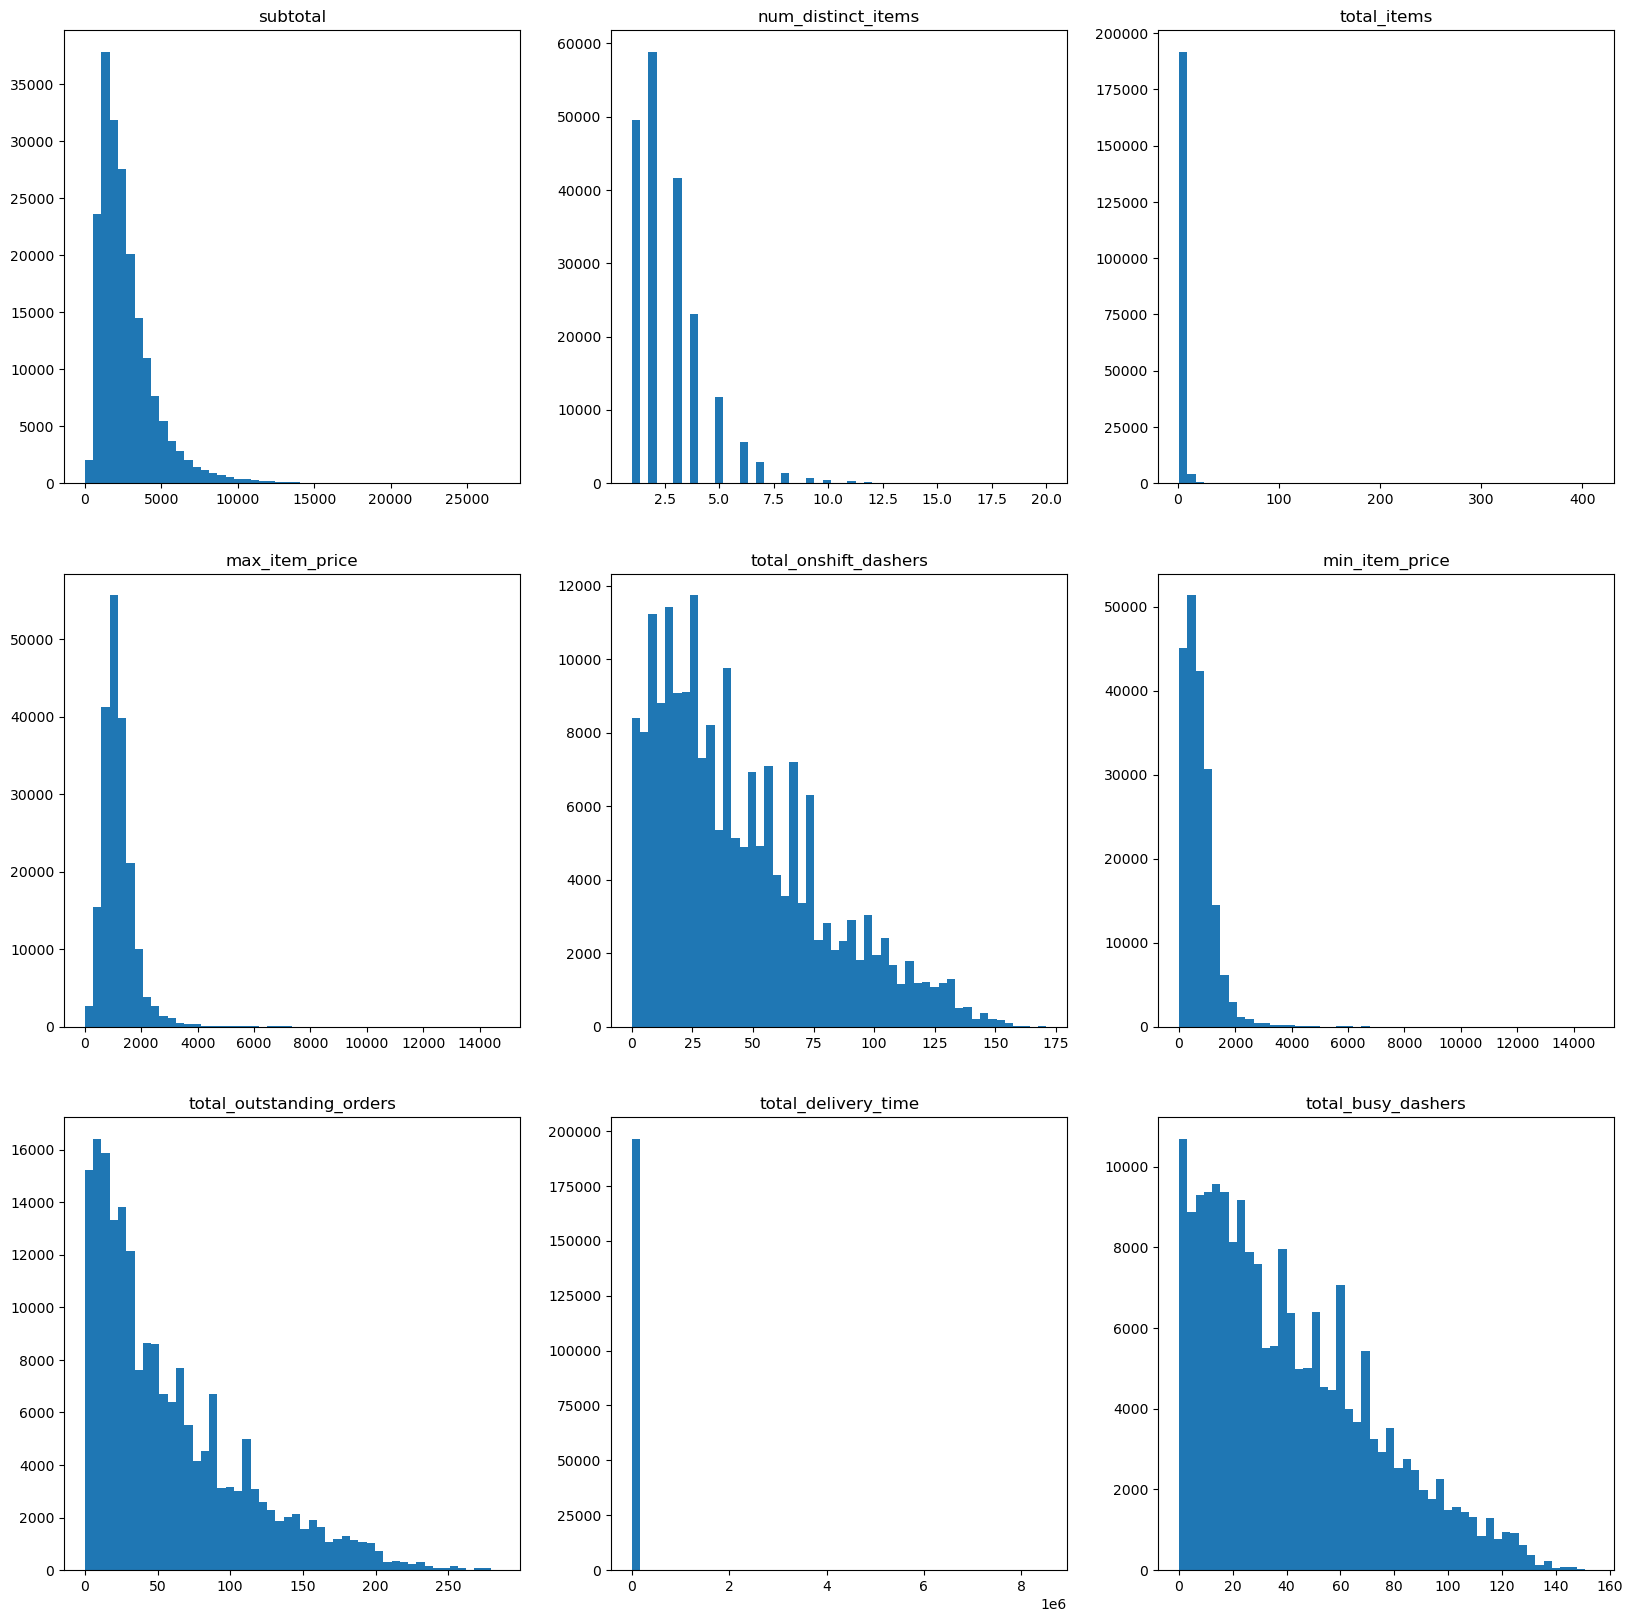

In [34]:
Numerical_column = ['total_items',  'subtotal', 'num_distinct_items', 'min_item_price','max_item_price','total_onshift_dashers'
                   ,'total_busy_dashers','total_outstanding_orders','total_delivery_time']
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for i,n in enumerate(Numerical_column):
    axes[i//3][(i%3)-1].hist(df[n],bins=50)
    axes[i//3][(i%3)-1].set_title(n)

## Outliers

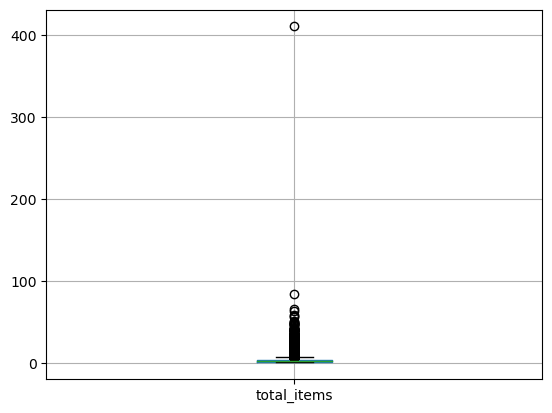

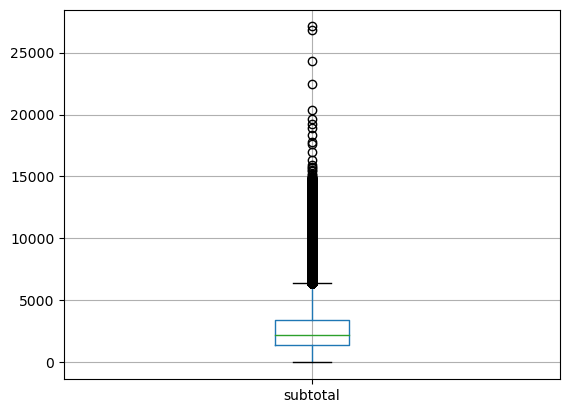

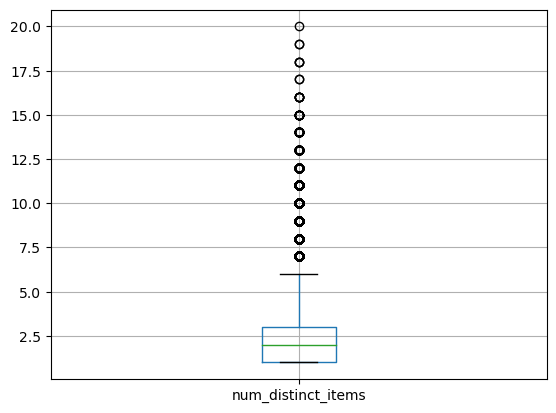

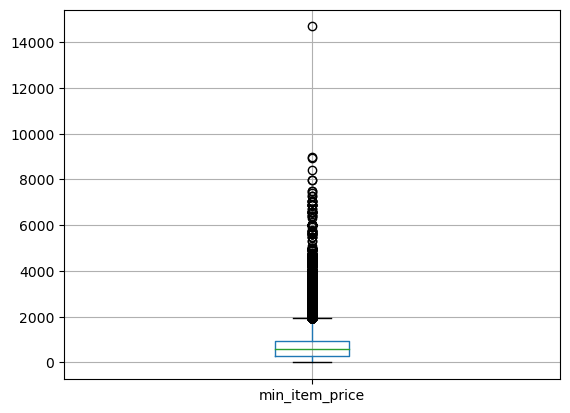

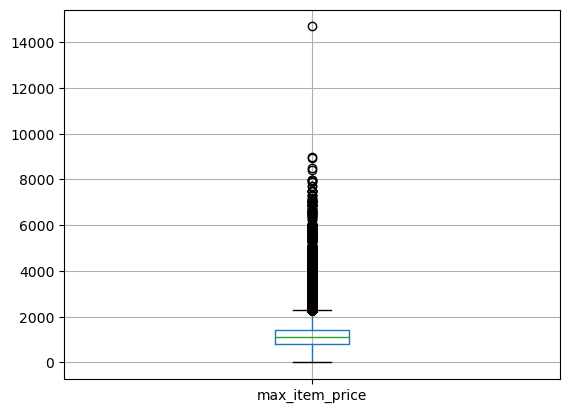

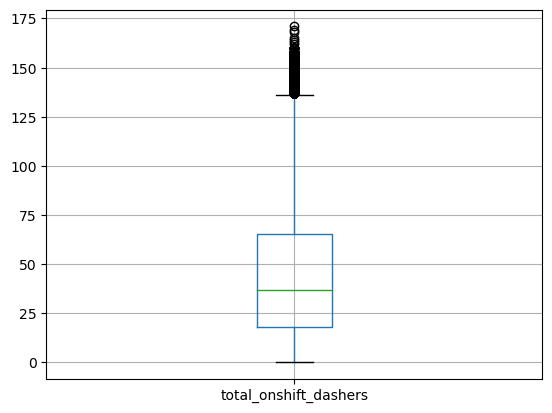

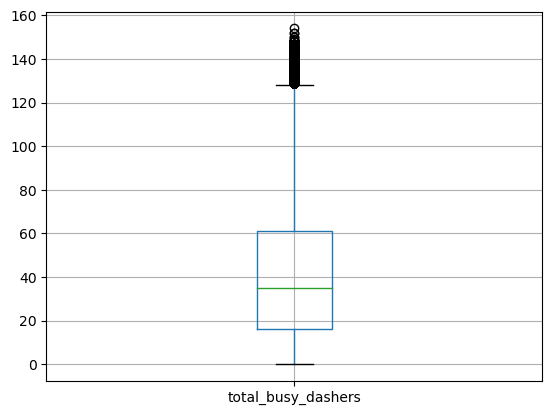

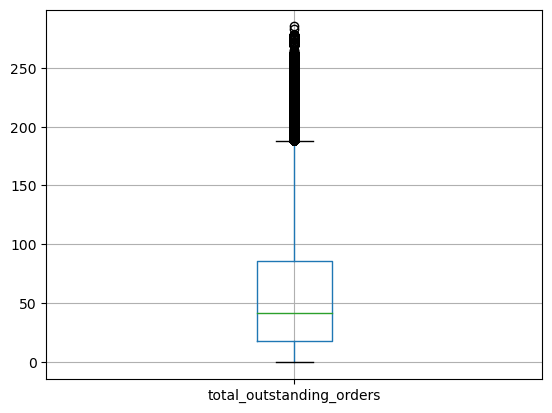

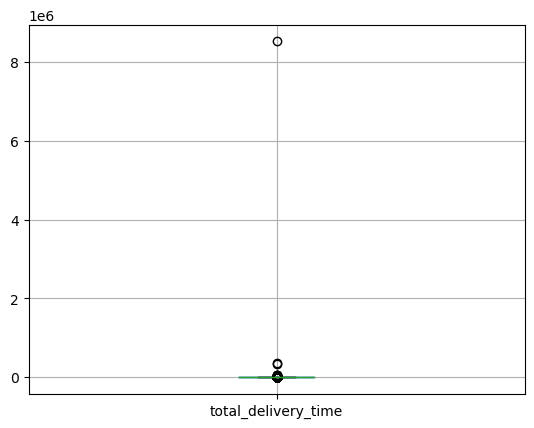

In [36]:
for i in (Numerical_column):
    boxplt = df.boxplot(column=[i])
    plt.show()

## Findings:
- We have one order with 411 items (Might be a system error -> will drop it)
- We also have one outlier with a delivery time 7 days (Will drop it)

In [40]:
df[df['total_items'] > 400]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,day_of_week,hour_of_day,month
47231,2.0,2015-02-06 00:42:39,2015-02-06 01:33:34,777,fast,4.0,411,3115,5,0,299,35.0,35.0,39.0,251,573.0,3055.0,4,0,2


In [46]:
df[df['total_delivery_time'] > 100000]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,day_of_week,hour_of_day,month


In [45]:
df.drop(df.loc[df['total_items'] == 411].index, inplace=True)
df.drop(df.loc[df['total_delivery_time'] == 8516859.0].index, inplace=True)
df.drop(df.loc[df['total_delivery_time'] == 332482.0].index, inplace=True)
df.drop(df.loc[df['total_delivery_time'] == 373879.0].index, inplace=True)

## Correlation

In [47]:
df.corr()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,day_of_week,hour_of_day,month
market_id,1.000000,0.017296,-0.021908,-0.006777,-0.016222,0.002555,-0.000131,-0.004901,0.063240,0.056826,0.061565,-0.053235,0.006615,-0.046679,-0.002488,-0.013888,0.040433
store_id,0.017296,1.000000,0.019516,-0.008245,-0.013463,-0.012866,-0.009291,-0.018716,-0.022409,-0.022537,-0.019915,0.017380,0.002003,-0.010087,-0.000688,0.010129,0.003758
order_protocol,-0.021908,0.019516,1.000000,0.008919,-0.053468,-0.023146,-0.045471,-0.090881,0.138757,0.143319,0.128810,-0.678260,-0.008501,-0.065978,-0.000875,0.015711,0.005088
total_items,-0.006777,-0.008245,0.008919,1.000000,0.594002,0.812416,-0.417498,-0.060858,0.032456,0.029017,0.034902,-0.024899,0.004876,0.118197,0.023108,-0.070270,-0.005370
subtotal,-0.016222,-0.013463,-0.053468,0.594002,1.000000,0.680947,0.037225,0.505503,0.129104,0.123794,0.127913,0.038736,0.034787,0.204312,0.032346,-0.184639,-0.006224
num_distinct_items,0.002555,-0.012866,-0.023146,0.812416,0.680947,1.000000,-0.448676,0.041685,0.064244,0.058976,0.065721,0.003339,0.022714,0.147695,0.029361,-0.114453,-0.002012
min_item_price,-0.000131,-0.009291,-0.045471,-0.417498,0.037225,-0.448676,1.000000,0.545891,0.043310,0.044798,0.042043,0.052923,0.003237,0.014969,-0.000047,-0.050687,0.002004
max_item_price,-0.004901,-0.018716,-0.090881,-0.060858,0.505503,0.041685,0.545891,1.000000,0.133468,0.131373,0.130832,0.084960,0.026702,0.126227,0.029872,-0.186475,0.004763
total_onshift_dashers,0.063240,-0.022409,0.138757,0.032456,0.129104,0.064244,0.043310,0.133468,1.000000,0.945448,0.937915,-0.176925,0.041857,0.071884,0.092498,-0.382442,0.025327
total_busy_dashers,0.056826,-0.022537,0.143319,0.029017,0.123794,0.058976,0.044798,0.131373,0.945448,1.000000,0.934771,-0.183227,0.040390,0.089290,0.077100,-0.358903,-0.042351


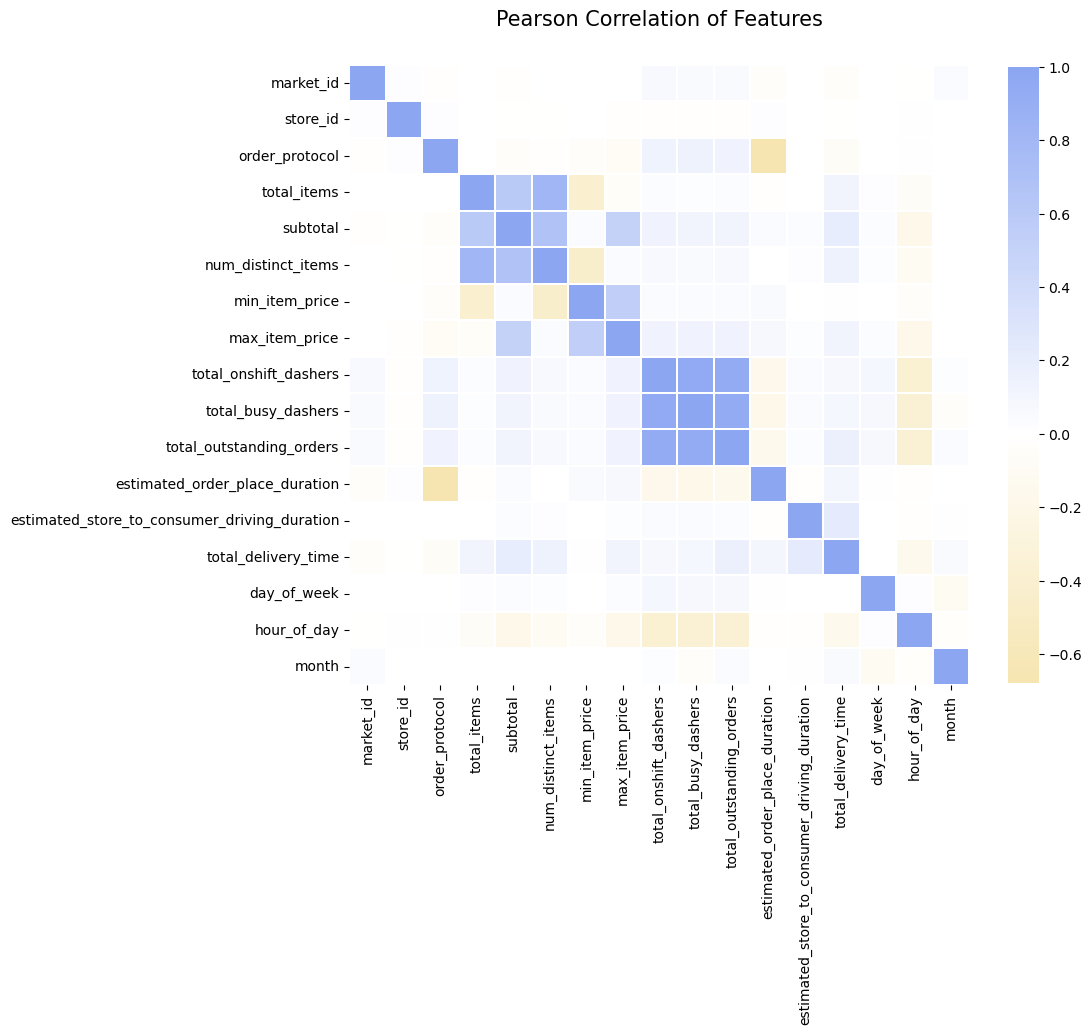

In [48]:
from matplotlib.colors import LinearSegmentedColormap
f, ax = plt.subplots(figsize = (10, 10))

colors = [gold_color, "#ffffff", blue_color]
color_positions = [1, 0, -1]

color_map = LinearSegmentedColormap.from_list("Custom", colors, N=256, gamma=1.0)

sns.heatmap(
    df.corr('pearson'), 
    cmap=color_map,
    square=True, 
    center=0,
    cbar_kws={'shrink': .8}, 
    ax=ax,
    annot=False, 
    linewidths=0.1, vmax=1.0, linecolor='white',
)

plt.title('Pearson Correlation of Features', y=1.05, size=15)
plt.show()

## Findings:
- There is a negative correlation between order_protocol and estimated_order_place_duration

<AxesSubplot:xlabel='market_id'>

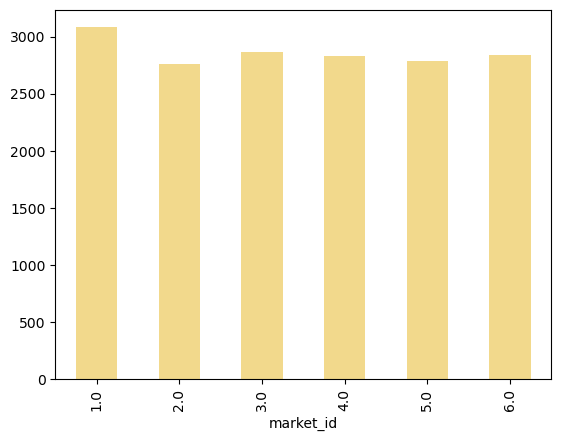

In [53]:
df.groupby(['market_id'])['total_delivery_time'].mean().plot.bar(color=gold_color)

- Average delivery time does not vary much by market id
- Market 1.0 has the highest average delivery time

<AxesSubplot:xlabel='store_primary_category'>

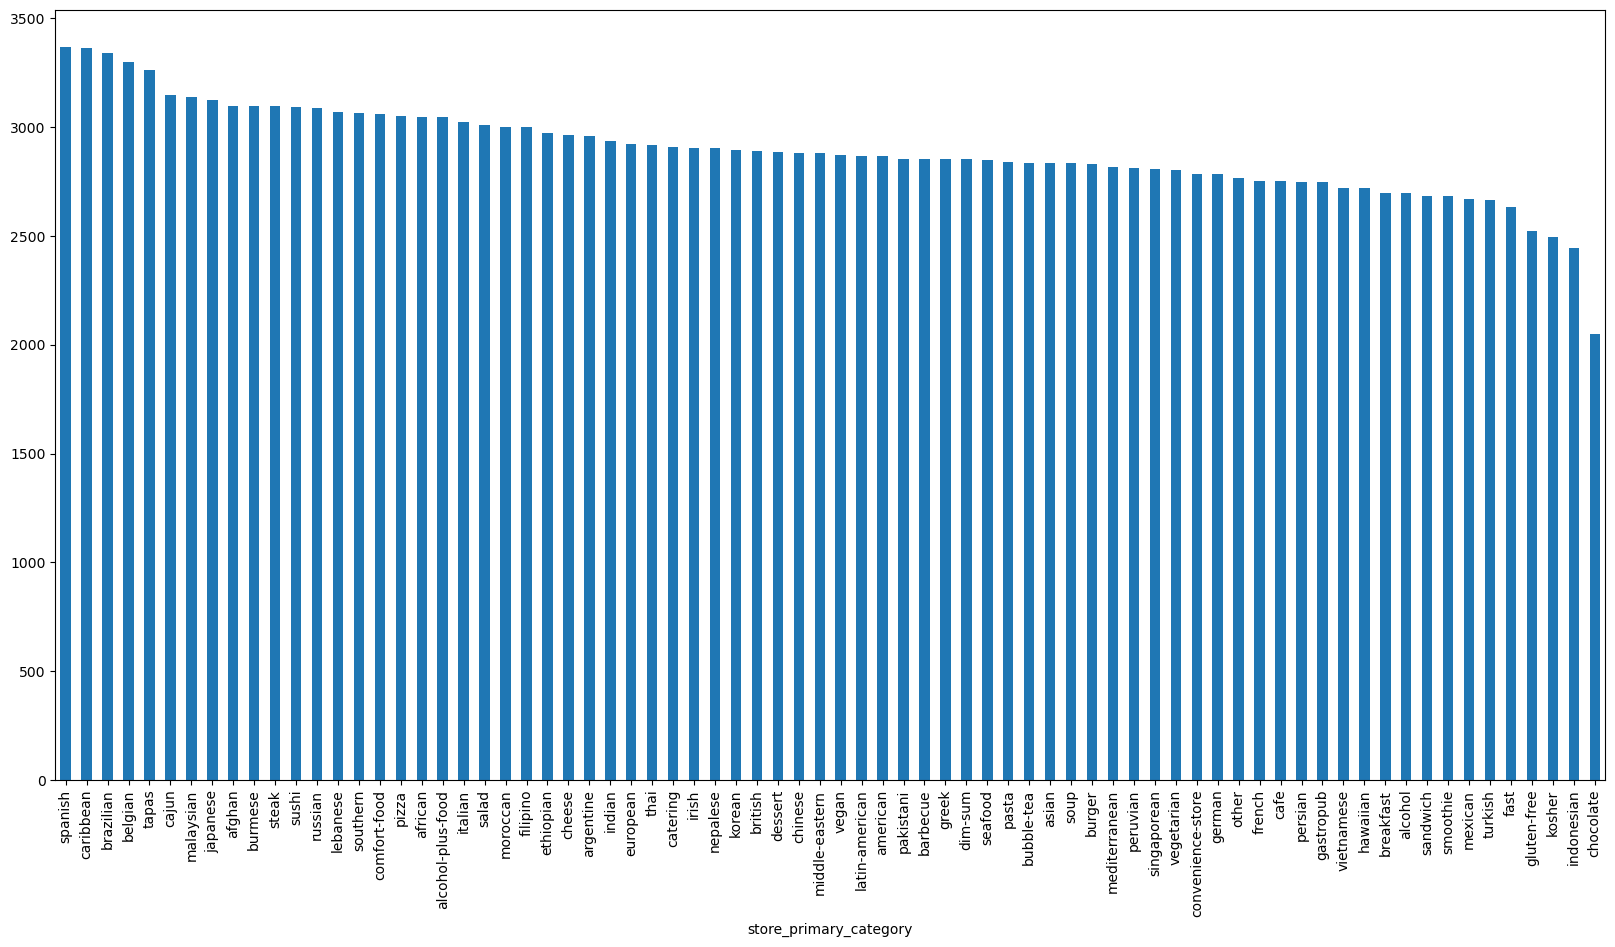

In [54]:
df.groupby(['store_primary_category'])['total_delivery_time'].mean().sort_values(ascending = False).plot.bar(figsize=(20,10))


- Average delivery time varies by store category

<AxesSubplot:xlabel='day_of_week'>

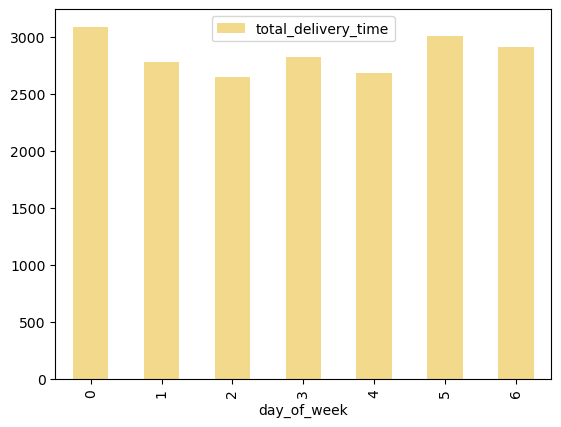

In [58]:
df.groupby(["day_of_week"]).mean()[['total_delivery_time']].plot.bar(color=gold_color, legend=True)


- Monday & the weekend have the highest average delivery time

<AxesSubplot:xlabel='hour_of_day'>

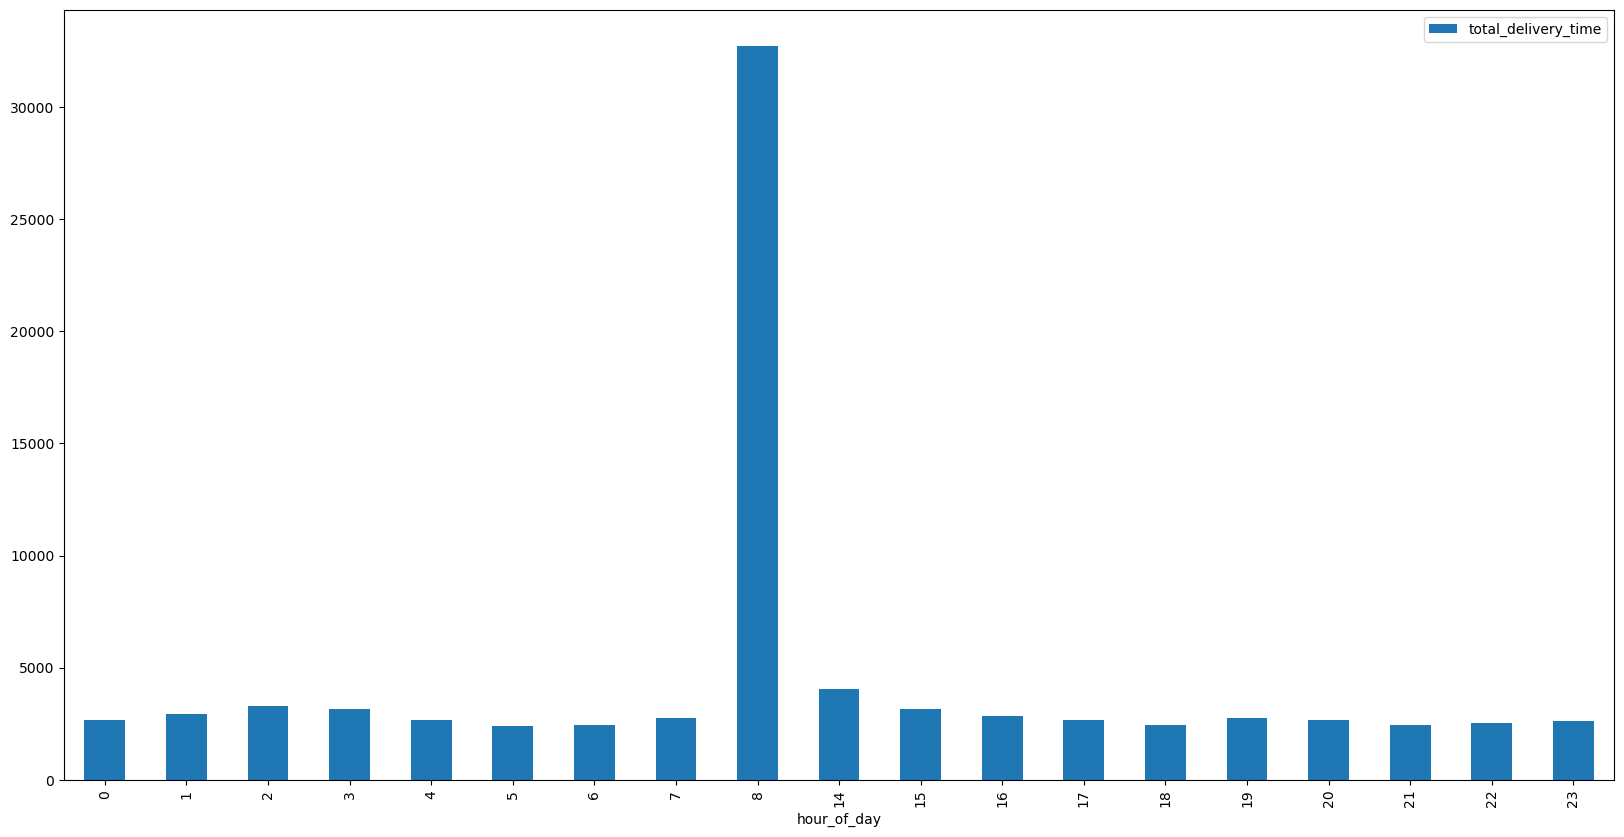

In [60]:
df.groupby(["hour_of_day"]).mean()[['total_delivery_time']].plot.bar(legend=True, figsize=(20,10))

#### The plot shows that there is an outlier with an order made at 8 am

In [61]:
df.groupby(by = "hour_of_day").mean()['total_delivery_time']

hour_of_day
0      2648.049179
1      2936.287478
2      3290.281264
3      3154.007011
4      2676.408400
5      2402.865807
6      2446.429587
7      2755.000000
8     32690.000000
14     4057.600000
15     3176.469159
16     2861.094196
17     2658.038666
18     2455.283770
19     2770.472414
20     2656.173456
21     2465.794901
22     2527.252989
23     2608.697723
Name: total_delivery_time, dtype: float64

In [69]:
df[(df['total_delivery_time'] > 32680) & (df['hour_of_day'] == 8)]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,total_delivery_time,day_of_week,hour_of_day,month
63505,2.0,2015-01-24 08:19:17,2015-01-24 17:24:07,441,american,5.0,4,2740,4,425,1095,0.0,0.0,0.0,251,730.0,32690.0,5,8,1


In [70]:
df = df.drop([63505])

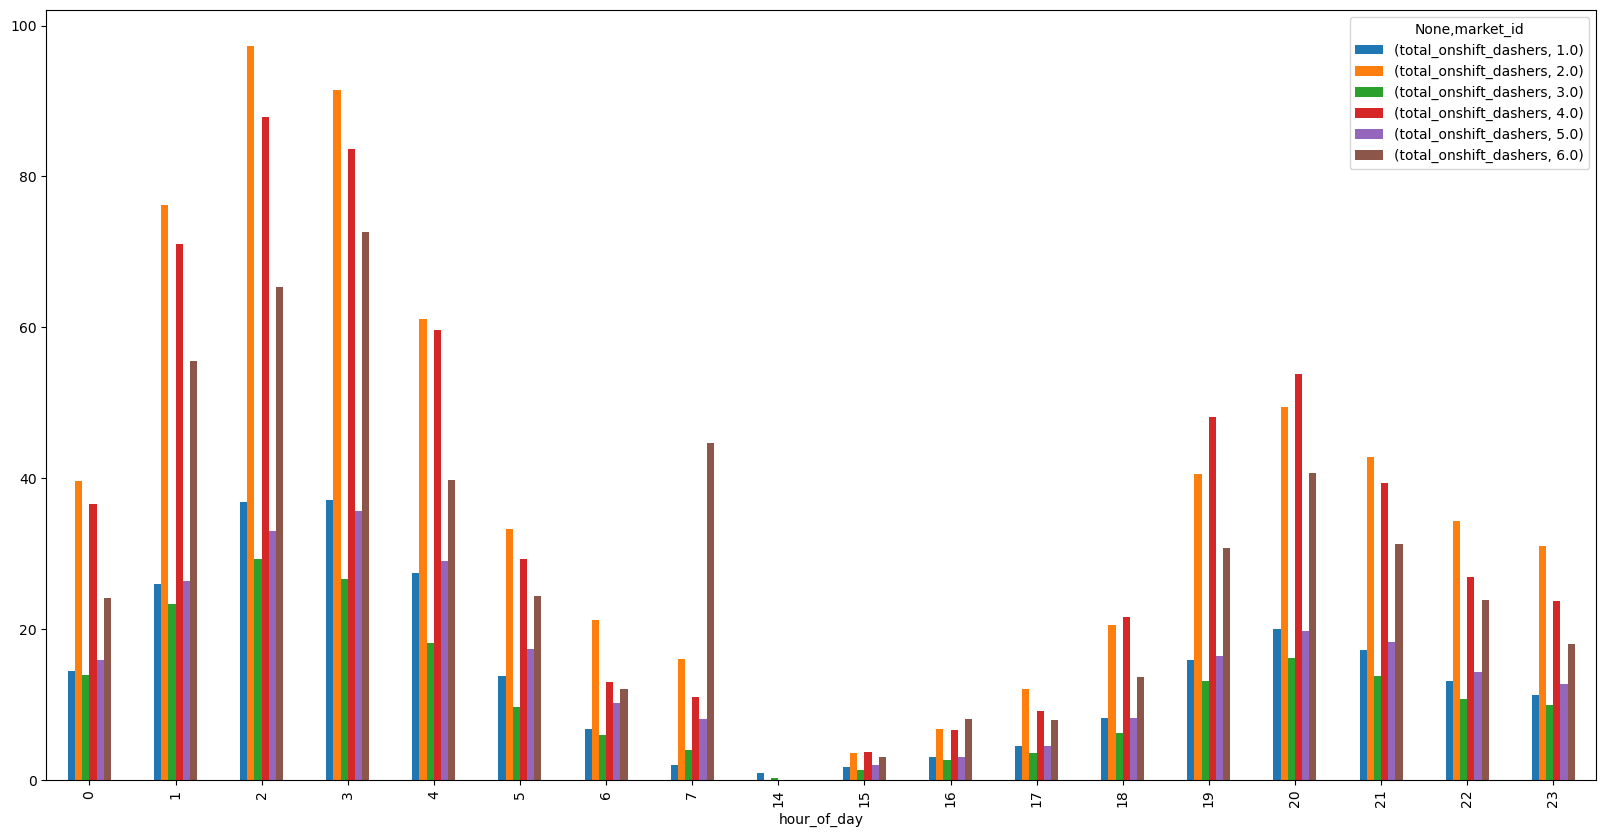

In [81]:
df.groupby(["hour_of_day",'market_id']).mean()[['total_onshift_dashers']].unstack('market_id').plot.bar(legend=True, figsize=(20,10))
pass

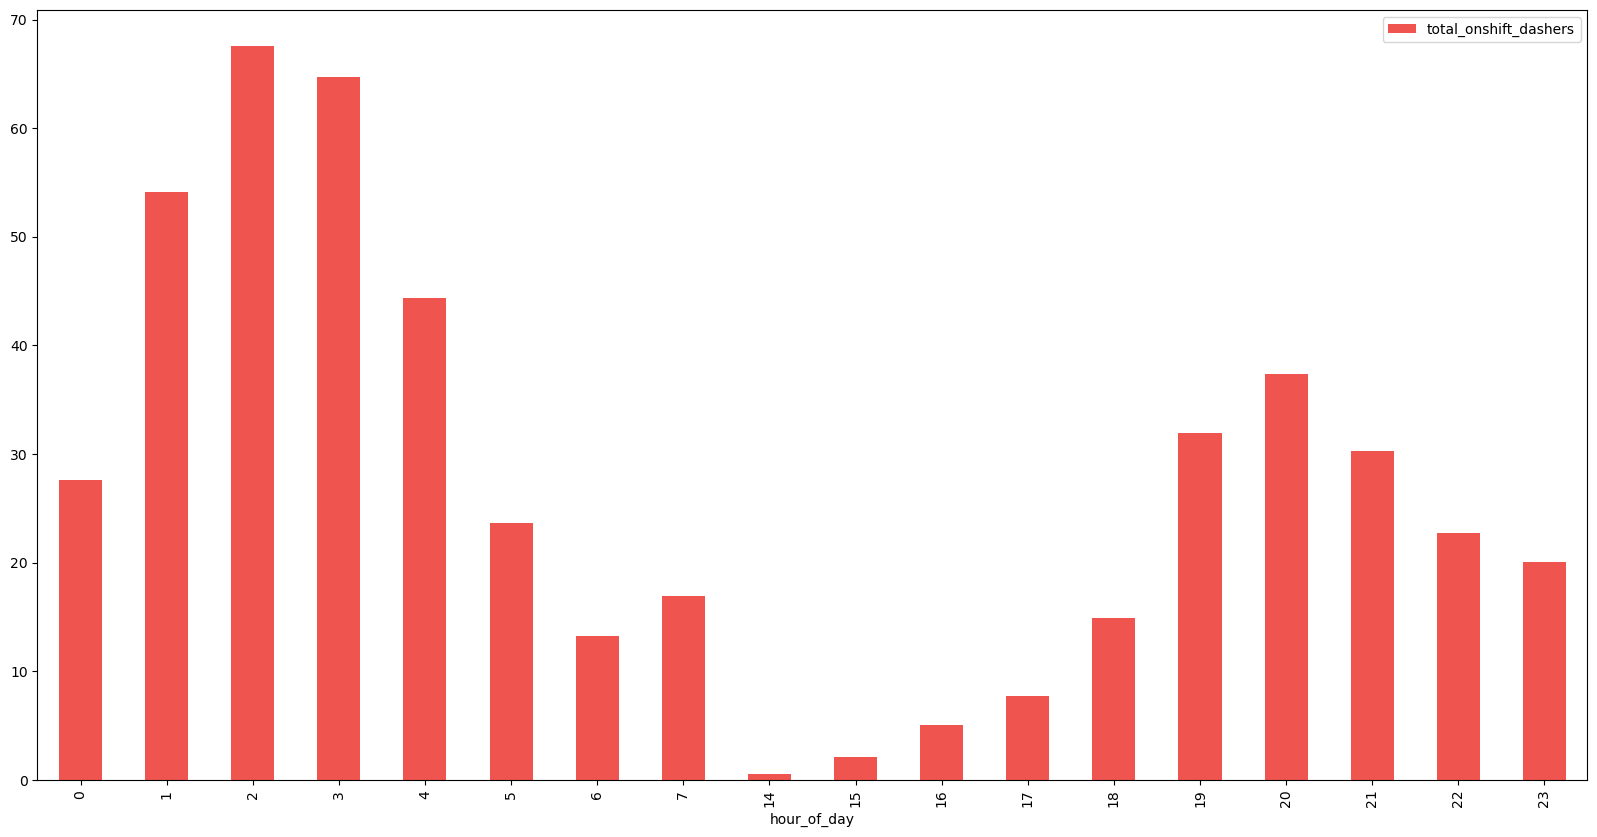

In [78]:
df.groupby(["hour_of_day"]).mean()[['total_onshift_dashers']].plot.bar(color=red_color, legend=True, figsize=(20,10))
pass

- There are not many dashers working between 8am and 3pm
- Market 2 and 4 have more dashers compared to the other markets.

# Modeling

In [125]:
def run_error_result(actual, predicted, name):
    def mape(actual, predicted): 
        return np.mean(np.abs((actual - predicted) / actual))

    mae_value = mean_absolute_error(actual, predicted)
    mape_value = mape(actual, predicted)
    rmse_value = np.sqrt(mean_squared_error(actual, predicted))
    r2_value = r2_score(actual, predicted)
    
    return pd.DataFrame({'MAE': [mae_value], 'MAPE': [mape_value], 'RMSE': [rmse_value], 'R2': [r2_value]}, index=[name])


In [84]:
def delivery_time_reg(data, columns):
    # Define the response variable
    y = data['total_delivery_time'].astype('int64')

    # Define the predictor variables
    X = data[columns]

    # Split the dataset into a training set and a testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=109)

    # Fit a linear regression model to the training data
    model = LinearRegression().fit(X_train, y_train)

    # Get the coefficients of the linear regression model, which indicate the importance of each feature
    importance = model.coef_

    # Plot the feature importance
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

    # Add a constant term to the predictor variables
    X_train = sm.add_constant(X_train) 
    X_test = sm.add_constant(X_test)

    # Fit another linear regression model to the training data using statsmodels
    model = sm.OLS(y_train, X_train).fit()

    # Print the summary of the model
    print(model.summary())

    # Make predictions for the testing set and the training set
    out_forecast = model.predict(X_test)
    in_forecast = model.predict(X_train)

    # Print the errors for the testing set and the training set
    print(run_error_result(y_test, out_forecast, 'Out-sample'))
    print(run_error_result(y_train, in_forecast, 'In-sample'))


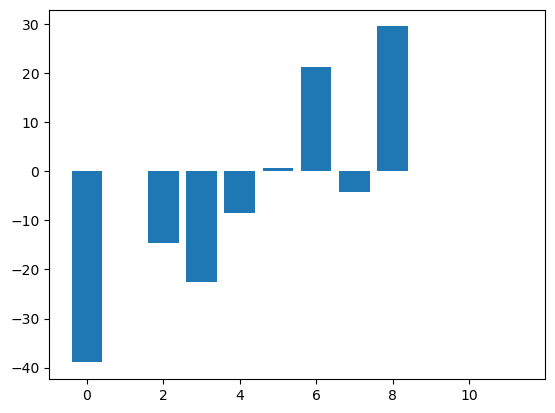

                             OLS Regression Results                            
Dep. Variable:     total_delivery_time   R-squared:                       0.155
Model:                             OLS   Adj. R-squared:                  0.155
Method:                  Least Squares   F-statistic:                     2409.
Date:                 Mon, 22 May 2023   Prob (F-statistic):               0.00
Time:                         22:29:54   Log-Likelihood:            -1.3168e+06
No. Observations:               157143   AIC:                         2.634e+06
Df Residuals:                   157130   BIC:                         2.634e+06
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const         

In [95]:
predictors = [
    'market_id',
    'store_id',
    'hour_of_day',
    'total_onshift_dashers',
    'total_busy_dashers',
    'day_of_week',
    'total_outstanding_orders',
    'total_items',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'subtotal'
]


delivery_time_reg(df, predictors)

## Findings
- P-values for day_of_week is very high indicating that we can NOT reject the null hypothesis and day_of_week is not relevant to our model.
- I argue that day_of_the_week is really important feature, We have seen already how delivery time would vary in the weekends.
- We will first use subset selection to make sure we already picked the right features for our regression model, then I will move to some other ML algorithms like RandomForest.

## Subset selection

- There are some other techniques like forward and backward selection which have a computational advantage over subset selection.
- However, with 12 predictors, we can still use subset selection

In [107]:
import itertools

def best_subset_selection(data, target, predictors, max_features):
    """
    Performs best subset selection on a given dataframe.

    Args:
        data (pd.DataFrame): The input data.
        target (str): The name of the target variable.
        predictors (list): The list of predictor names.
        max_features (int): The maximum number of features to consider.

    Returns:
        pd.DataFrame: A DataFrame with the results of the best subset selection.
    """
    # Initialize a dataframe to store the results
    results = []

    # Loop over each size
    for k in range(1, max_features + 1):
        # Loop over each possible combination of k features
        for combo in itertools.combinations(predictors, k):
            # Fit the model and get the AIC
            model = sm.OLS(data[target], sm.add_constant(data[list(combo)])).fit()
            aic = model.aic

            # Append the results to our list
            results.append({
                "num_features": k,
                "features": combo,
                "AIC": aic
            })

    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)

    # Find the model with the lowest AIC for each number of features
    best_models = results_df.loc[results_df.groupby("num_features")["AIC"].idxmin()]

    return best_models


In [109]:
best_models = best_subset_selection(
    df, 'total_delivery_time', predictors, max_features=12
)

In [111]:
best_models['AIC'].min()

3298083.1169210584

In [112]:
best_models[best_models['AIC'] == 3298083.1169210584]['features'].iloc[0]

('market_id',
 'store_id',
 'hour_of_day',
 'total_onshift_dashers',
 'total_busy_dashers',
 'total_outstanding_orders',
 'total_items',
 'num_distinct_items',
 'min_item_price',
 'max_item_price',
 'subtotal')

## Findings
- Subset selection also showed that day_of_the_week is not an important feature.

# RandomForest

In [127]:
y = df['total_delivery_time']
X = df[predictors]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=109)

rf = RandomForestRegressor(n_estimators = 300,min_samples_split=8,max_features =4)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=4, min_samples_split=8, n_estimators=300)

Text(0.5, 0, 'Relative Importance')

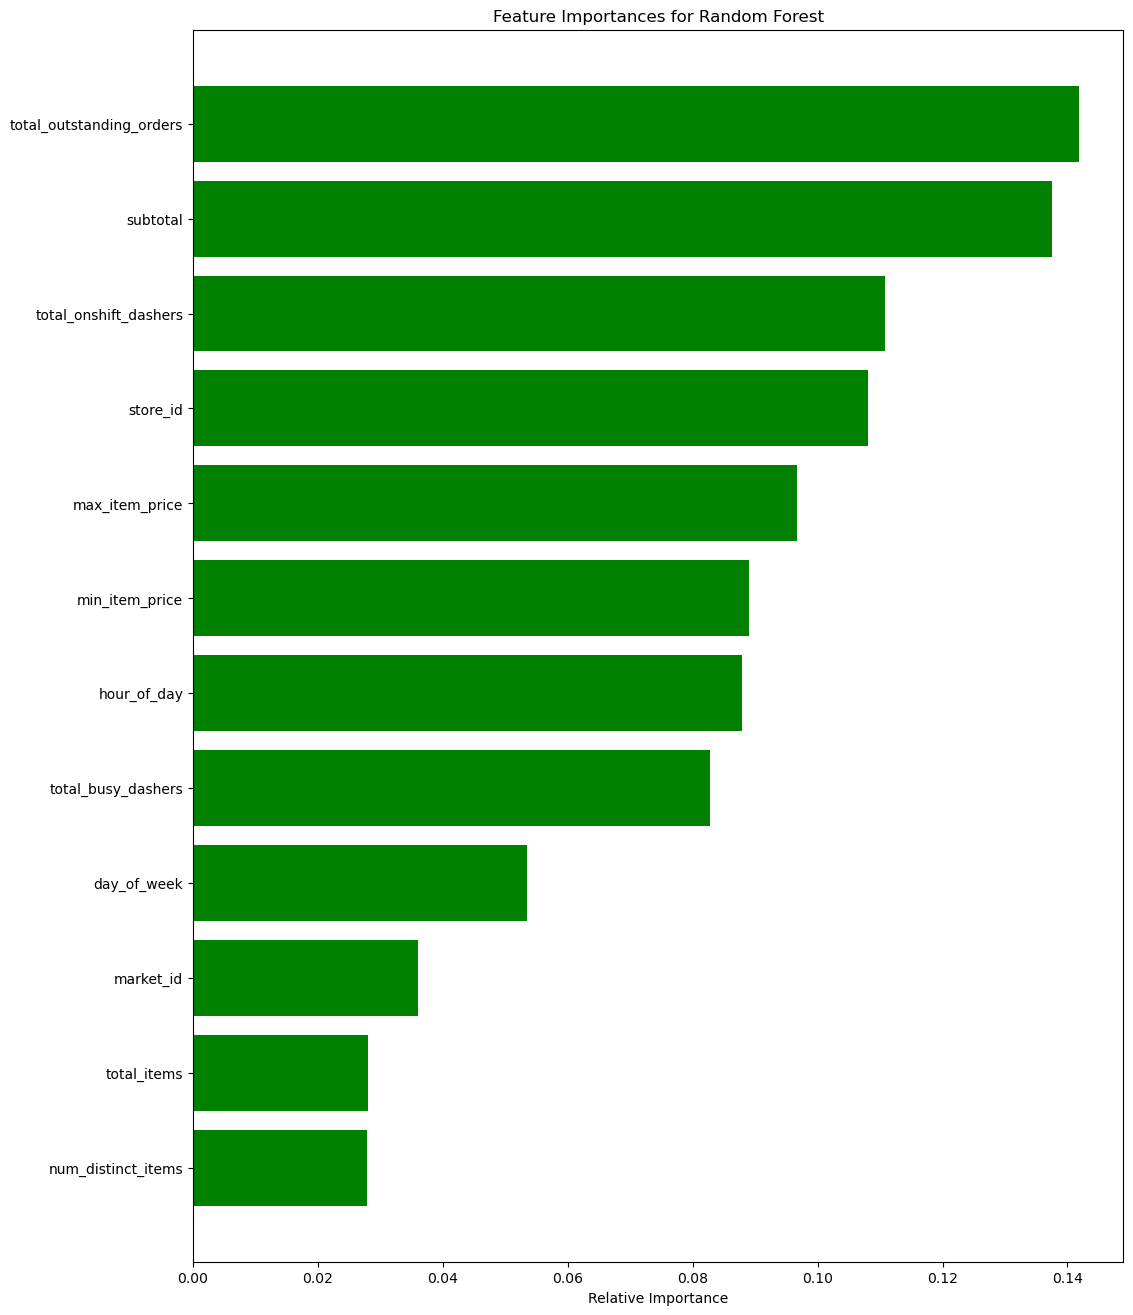

In [128]:
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,16))
plt.title('Feature Importances for Random Forest')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

In [129]:
## predict test set  (out-sample)
out_forecast = rf.predict(X_test)
## predict train set  (in-sample)

in_forecast = rf.predict(X_train)

print(run_error_result(y_test, out_forecast,'Out-sample'))
print(run_error_result(y_train, in_forecast,'In-sample'))

                   MAE      MAPE         RMSE        R2
Out-sample  698.500144  0.267468  1077.340803  0.219792
                  MAE      MAPE        RMSE        R2
In-sample  398.025613  0.152215  601.775733  0.724995


In [130]:
exclude_columns = [
    'day_of_week',
    'market_id',
    'total_items',
    'num_distinct_items'
]  

final_predictors = [col for col in predictors if col not in exclude_columns]


In [138]:
y = df['total_delivery_time']
X = df[predictors]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=109)

rf = RandomForestRegressor(n_estimators = 300,min_samples_split=8,max_features =4)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=4, min_samples_split=8, n_estimators=300)

In [139]:
## predict test set  (out-sample)
out_forecast = rf.predict(X_test)
## predict train set  (in-sample)

in_forecast = rf.predict(X_train)

print(run_error_result(y_test, out_forecast,'Out-sample'))
print(run_error_result(y_train, in_forecast,'In-sample'))

                   MAE      MAPE         RMSE        R2
Out-sample  698.060414  0.267193  1077.367179  0.219753
                 MAE      MAPE        RMSE        R2
In-sample  398.21527  0.152245  601.658016  0.725103
